In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-03-22 12:28:57.089485: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 12:29:01.608683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 12:29:01.612041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 12:29:02.230223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 12:29:03.341329: I tensorflow/core/platform/cpu_feature_guar

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-22 12:29:54.762186: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 12:29:58.880118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 12:29:58.880159: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import keras
print(keras.__version__)

3.0.0


In [ ]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

(train_ds, validation_ds, test_ds), info = tfds.load(
    "cifar10",
    # Reserve 10% for validation and 10% for test
    split=["train[:20%]", "train[20%:25%]", "train[25%:30%]"],
    as_supervised=True,  # Include labels
    with_info=True
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

/mnt/c/projects/scene_perception/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-22 12:30:38.907137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 12:30:38.907225: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 12:30:38.907242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 12:30:39.499703: 

Number of training samples: 10000
Number of validation samples: 2500
Number of test samples: 2500


In [4]:
num_classes = info.features["label"].num_classes
class_names = info.features["label"].names
print(num_classes)
print(class_names)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


2024-03-22 12:32:26.813590: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


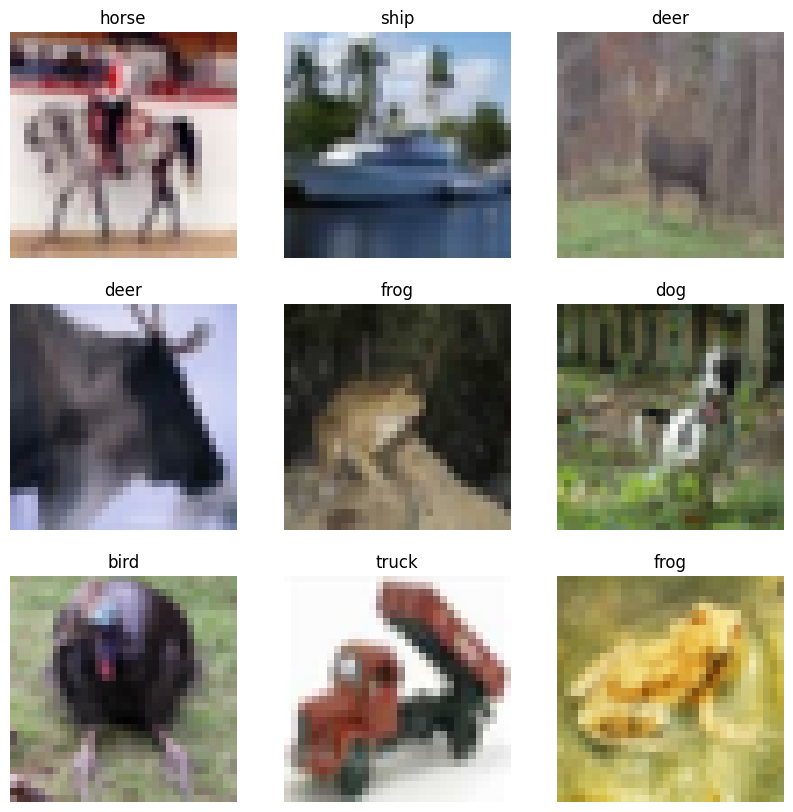

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(info.features["label"].names[label])
    plt.axis("off")

In [6]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [7]:
augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]

augmenter = keras.Sequential(
    [
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.1)
    ],
)


def data_augmentation(x):
    # for layer in augmentation_layers:
    #     x = layer(x)
    x = augmenter(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [8]:
batch_size = 32

train_ds = train_ds.batch(batch_size).prefetch(1)
validation_ds = validation_ds.batch(batch_size).prefetch(1)
test_ds = test_ds.batch(batch_size).prefetch(1)

2024-03-22 12:32:56.483948: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-03-22 12:32:59.204701: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


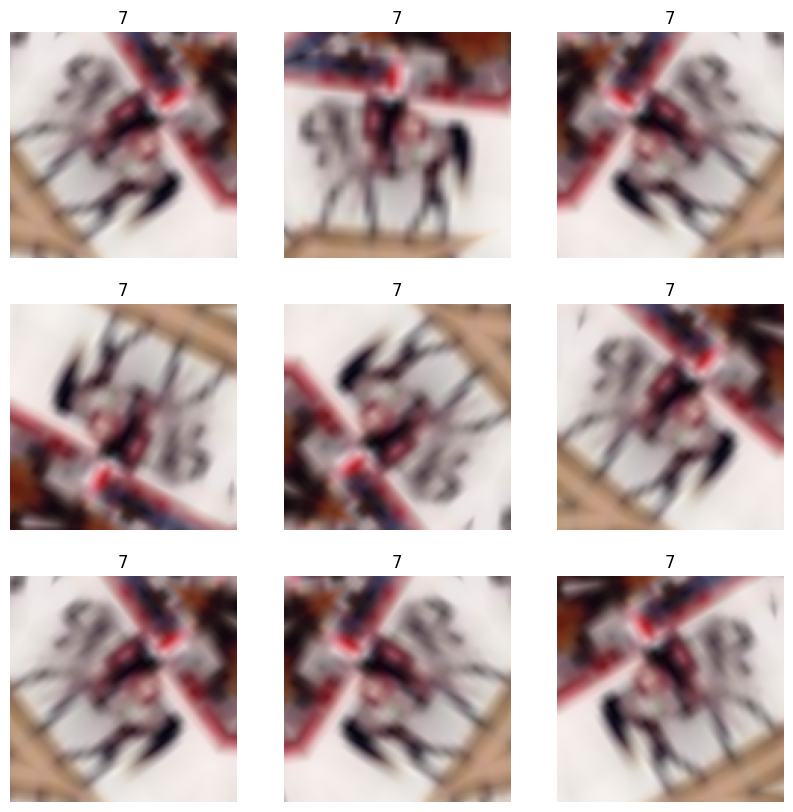

In [9]:
import numpy as np
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(first_image)
        plt.imshow(np.array(augmented_image).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [10]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape             ┃ Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 150, 150, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)       │ 20,861… │   N   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)             │       0 │   -   │
│ (GlobalAveragePooling2D)    │                          │         │       │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)             │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dense (Dense)               │ (None, 10)               │  20,490 │   Y   │
└─────────────────────────────┴──────────────────────────┴─────────┴───────┘

 Total params: 20,881,970 (79.66 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

epochs = 10
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 190ms/step - loss: 0.9358 - sparse_categorical_accuracy: 0.6840 - val_loss: 0.5656 - val_sparse_categorical_accuracy: 0.8032
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 227ms/step - loss: 0.8936 - sparse_categorical_accuracy: 0.6947 - val_loss: 0.5546 - val_sparse_categorical_accuracy: 0.8076
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 255ms/step - loss: 0.9042 - sparse_categorical_accuracy: 0.6906 - val_loss: 0.5600 - val_sparse_categorical_accuracy: 0.8076
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 266ms/step - loss: 0.8719 - sparse_categorical_accuracy: 0.6973 - val_loss: 0.5540 - val_sparse_categorical_accuracy: 0.8072
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 263ms/step - loss: 0.8719 - sparse_categorical_accuracy: 0.6959 - val_loss: 0.5520 - val_sparse_categorical_accuracy: 0.8100
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 273ms/step - loss: 0.8623 - sparse_categorical_accuracy: 0.6981 - val_loss: 

In [16]:
print(model.history.history)
print(model.history.__dir__())
print(model.history.epoch)

{'loss': [0.9507132172584534, 0.9077338576316833, 0.918055534362793, 0.8814235925674438, 0.8667298555374146, 0.8572022318840027, 0.8473696112632751, 0.8586642146110535, 0.8557279109954834, 0.8388441801071167], 'sparse_categorical_accuracy': [0.675000011920929, 0.6916000247001648, 0.6811000108718872, 0.6942999958992004, 0.7008000016212463, 0.7042999863624573, 0.7091000080108643, 0.703000009059906, 0.7099999785423279, 0.7134000062942505], 'val_loss': [0.5656068325042725, 0.5545856952667236, 0.5600489377975464, 0.5540002584457397, 0.552023708820343, 0.5455007553100586, 0.557466983795166, 0.5629980564117432, 0.5463963747024536, 0.543649435043335], 'val_sparse_categorical_accuracy': [0.8032000064849854, 0.8076000213623047, 0.8076000213623047, 0.807200014591217, 0.8100000023841858, 0.8059999942779541, 0.8044000267982483, 0.8064000010490417, 0.807200014591217, 0.8148000240325928]}
['validation_data', '_model', 'history', 'params', 'epoch', '__module__', '__doc__', '__init__', 'on_train_begin'

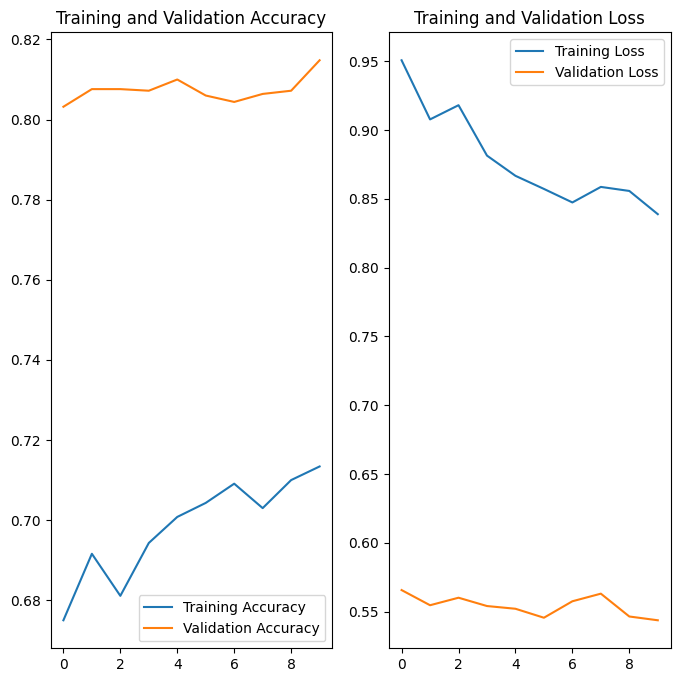

In [19]:
def plot_hist(hist):
    acc = hist.history['sparse_categorical_accuracy']
    val_acc = hist.history['val_sparse_categorical_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = hist.epoch

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


plot_hist(model.history)

In [20]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.5373 - sparse_categorical_accuracy: 0.8066
Test accuracy : 0.8083999752998352


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)